In [49]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import cv2
import tensorflow as tf
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
FILE_PATH = '/content/gdrive/MyDrive/Colab Notebooks/PlantVillage'

DIR_PATH = Path(FILE_PATH)

filepaths = list(DIR_PATH.glob(r'**/*.JPG')) + list(DIR_PATH.glob(r'**/*.jpg')) + list(DIR_PATH.glob(r'**/*.png')) + list(DIR_PATH.glob(r'**/*.PNG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

df = pd.concat([filepaths, labels], axis=1)

In [4]:
df

,Filepath,Label
0,/content/gdrive/MyDrive/Colab Notebooks/PlantV...,Potato___Late_blight
1,/content/gdrive/MyDrive/Colab Notebooks/PlantV...,Potato___Late_blight
2,/content/gdrive/MyDrive/Colab Notebooks/PlantV...,Potato___Late_blight
3,/content/gdrive/MyDrive/Colab Notebooks/PlantV...,Potato___Late_blight
4,/content/gdrive/MyDrive/Colab Notebooks/PlantV...,Potato___Late_blight
...,...,...
2147,/content/gdrive/MyDrive/Colab Notebooks/PlantV...,Potato___healthy
2148,/content/gdrive/MyDrive/Colab Notebooks/PlantV...,Potato___healthy
2149,/content/gdrive/MyDrive/Colab Notebooks/PlantV...,Potato___healthy
2150,/content/gdrive/MyDrive/Colab Notebooks/PlantV...,Potato___healthy


In [5]:
test = set(df['Label'])

test

{'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy'}

In [6]:
df['Label'].isnull().sum()

0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152 entries, 0 to 2151
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  2152 non-null   object
 1   Label     2152 non-null   object
dtypes: object(2)
memory usage: 33.8+ KB


In [8]:
df.describe()

,Filepath,Label
count,2152,2152
unique,2152,3
top,/content/gdrive/MyDrive/Colab Notebooks/PlantV...,Potato___Late_blight
freq,1,1000


In [9]:
df['Label'].value_counts()

Label
Potato___Late_blight     1000
Potato___Early_blight    1000
Potato___healthy          152
Name: count, dtype: int64

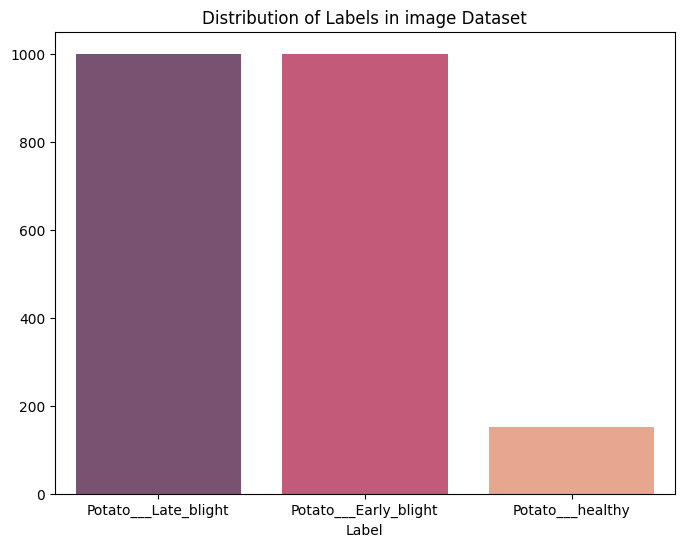

In [10]:
label_counts = df['Label'].value_counts()

plt.figure(figsize=(8,6))
plt.title('Distribution of Labels in image Dataset')
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, hue=label_counts.index, palette='rocket')

plt.show()

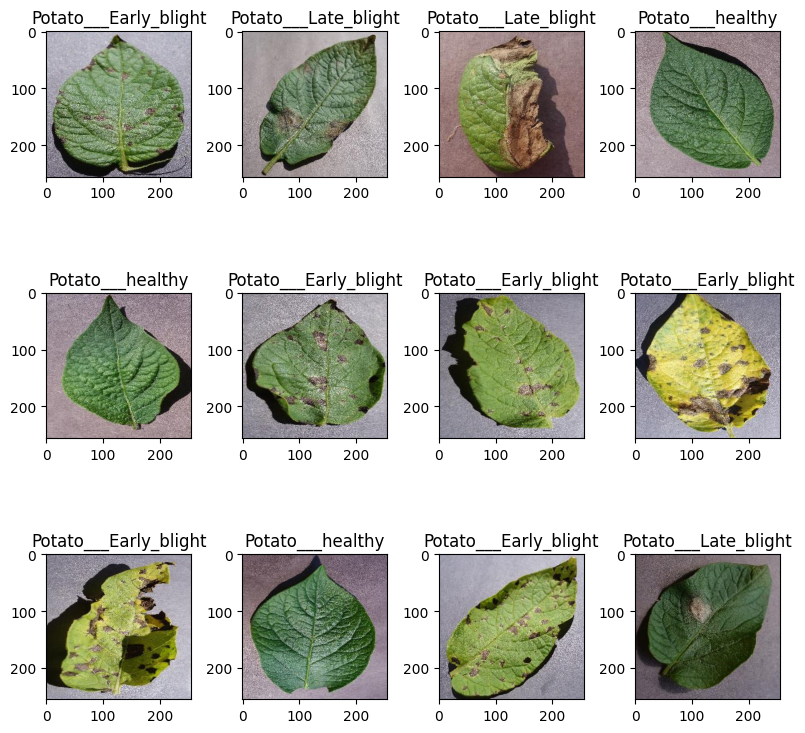

In [11]:
random_idx = np.random.randint(0, len(df), 12)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(8,8))

for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df.Filepath[random_idx[i]]))
  ax.set_title(df['Label'][random_idx[i]])

plt.tight_layout()

plt.show()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['Filepath'], df['Label'], test_size=0.2, shuffle=True, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1721,), (431,), (1721,), (431,))

In [16]:
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [17]:
categories = len(set(df['Label']))

categories

3

In [19]:
y_train_encoded = to_categorical(y_train_encoded, categories)
y_test_encoded = to_categorical(y_test_encoded, categories)

In [20]:
X_train.shape, X_test.shape, y_train_encoded.shape, y_test_encoded.shape

((1721,), (431,), (1721, 3), (431, 3))

In [25]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

df_train = pd.DataFrame({
    'Filepath': X_train,
    'Label': y_train
})

df_test = pd.DataFrame({
    'Filepath': X_test,
    'Label': y_test
})

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='train_images',
    x_col='Filepath',
    y_col='Label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory='test_images',
    x_col='Filepath',
    y_col='Label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 1721 validated image filenames belonging to 3 classes.
Found 431 validated image filenames belonging to 3 classes.


In [27]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(categories, activation='softmax')
])

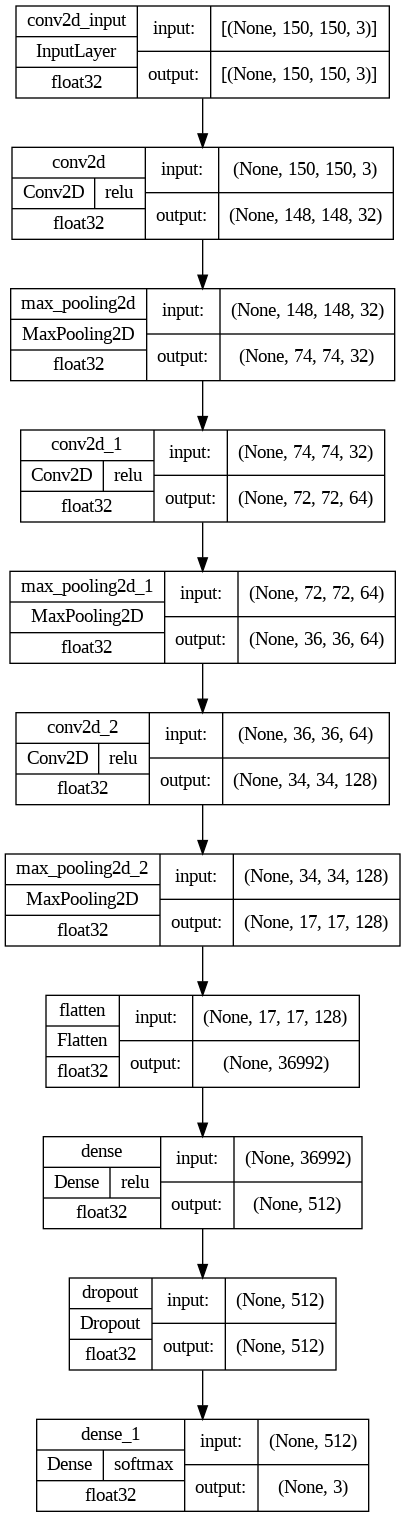

In [28]:
plot_model(model, show_dtype=True, show_layer_activations=True, show_shapes=True)

In [30]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [33]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/5
53/53 [==============================] - 535s 10s/step - loss: 0.7735 - accuracy: 0.6163 - val_loss: 0.4683 - val_accuracy: 0.8486
Epoch 2/5
53/53 [==============================] - 104s 2s/step - loss: 0.4085 - accuracy: 0.8478 - val_loss: 0.2551 - val_accuracy: 0.8942
Epoch 3/5
53/53 [==============================] - 104s 2s/step - loss: 0.2491 - accuracy: 0.9059 - val_loss: 0.1867 - val_accuracy: 0.9303
Epoch 4/5
53/53 [==============================] - 101s 2s/step - loss: 0.1619 - accuracy: 0.9491 - val_loss: 0.1545 - val_accuracy: 0.9519
Epoch 5/5
53/53 [==============================] - 100s 2s/step - loss: 0.1426 - accuracy: 0.9449 - val_loss: 0.2245 - val_accuracy: 0.9183


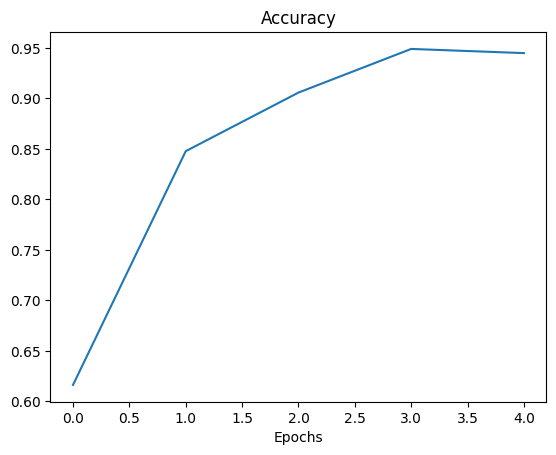

In [37]:
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')

plt.show()

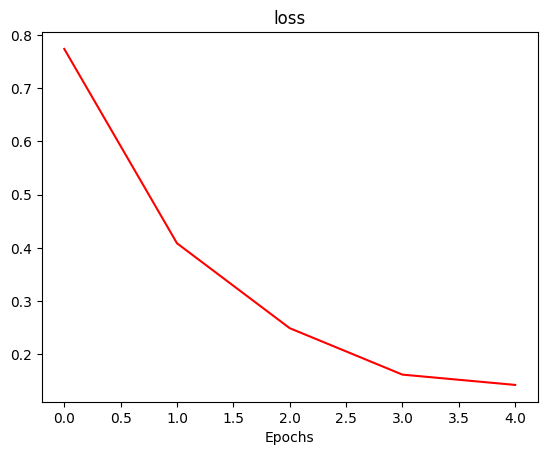

In [39]:
plt.plot(history.history['loss'], c='r')
plt.title('loss')
plt.xlabel('Epochs')

plt.show()

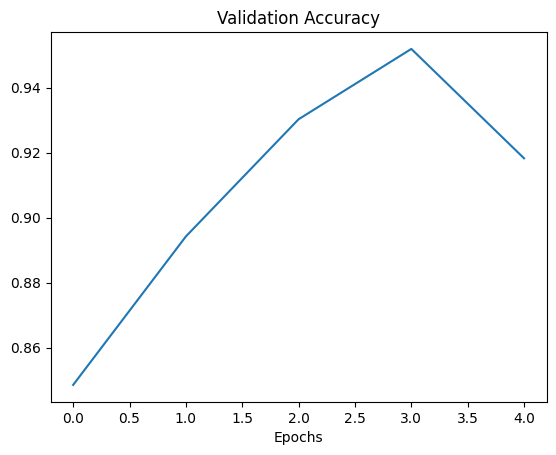

In [41]:
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('Epochs')

plt.show()

In [45]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Test accuracy: {accuracy} Test Loss: {loss}')

14/14 [==============================] - 7s 489ms/step - loss: 0.2186 - accuracy: 0.9211
Test accuracy: 0.9211136698722839 Test Loss: 0.21861153841018677


In [46]:
model.save('potato_disease_classifier_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [48]:
def predict_random_image(model, generator, label_encoder):
    batch = next(generator)
    images, labels = batch

    idx = random.randint(0, len(images) - 1)

    plt.imshow(images[idx])
    actual_label = label_encoder.inverse_transform([np.argmax(labels[idx])])[0]
    plt.title(f'Actual: {actual_label}')
    plt.show()

    image = images[idx].reshape(1, 150, 150, 3)
    y_pred = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(y_pred)])

    print(f'Prediction probabilities: {y_pred}')
    print(f'Predicted class: {predicted_class[0]}')

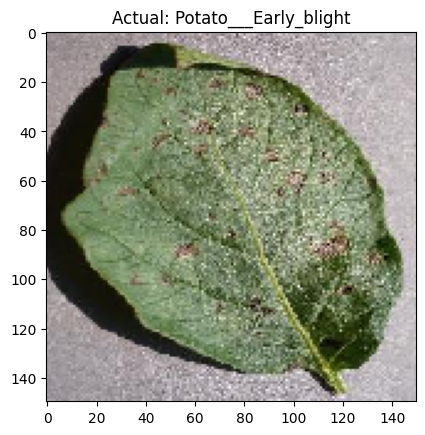

1/1 [==============================] - 0s 366ms/step
Prediction probabilities: [[9.9842286e-01 1.5758078e-03 1.3300850e-06]]
Predicted class: Potato___Early_blight


In [50]:
model = load_model('potato_disease_classifier_model.h5')

predict_random_image(model, validation_generator, label_encoder)